In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm

from sklearn import svm

import xarrayaita.aita
import pickle

In [2]:
file = open('data/craft/CI02.xr', 'rb')
ds_CI02 = pickle.load(file)
file.close()

file = open('data/craft/CI04.xr', 'rb')
ds_CI04 = pickle.load(file)
file.close()

file = open('data/craft/CI06.xr', 'rb')
ds_CI06 = pickle.load(file)
file.close()

file = open('data/craft/CI09.xr', 'rb')
ds_CI09 = pickle.load(file)
file.close()

file = open('data/craft/CI21.xr', 'rb')
ds_CI21 = pickle.load(file)
file.close()

In [3]:
TJ_CI02 = utils.load_tj_data("data/TJ/TJ_CI02.npy")
TJ_CI04 = utils.load_tj_data("data/TJ/TJ_CI04.npy")
TJ_CI06 = utils.load_tj_data("data/TJ/TJ_CI06.npy")
TJ_CI09 = utils.load_tj_data("data/TJ/TJ_CI09.npy")
TJ_CI21 = utils.load_tj_data("data/TJ/TJ_CI21.npy")

tj_to_skip_CI02 = list(TJ_CI02.loc[(TJ_CI02.RX.isna())].index)
tj_to_skip_CI04 = list(TJ_CI04.loc[(TJ_CI04.RX.isna())].index)
tj_to_skip_CI06 = list(TJ_CI06.loc[(TJ_CI06.RX.isna())].index)
tj_to_skip_CI09 = list(TJ_CI09.loc[(TJ_CI09.RX.isna())].index)
tj_to_skip_CI21 = list(TJ_CI21.loc[(TJ_CI21.RX.isna())].index)

TJ_CI02 = TJ_CI02.dropna()
TJ_CI04 = TJ_CI04.dropna()
TJ_CI06 = TJ_CI06.dropna()
TJ_CI09 = TJ_CI09.dropna()
TJ_CI21 = TJ_CI21.dropna()

In [4]:
X1 = TJ_CI02.iloc[:,((TJ_CI02.columns != 'RX'))]
X2 = TJ_CI04.iloc[:,((TJ_CI04.columns != 'RX'))]
X3 = TJ_CI06.iloc[:,((TJ_CI06.columns != 'RX'))]
X4 = TJ_CI09.iloc[:,((TJ_CI09.columns != 'RX'))]
X5 = TJ_CI21.iloc[:,((TJ_CI21.columns != 'RX'))]

y1 = TJ_CI02.iloc[:, 0]
y2 = TJ_CI04.iloc[:, 0]
y3 = TJ_CI06.iloc[:, 0]
y4 = TJ_CI09.iloc[:, 0]
y5 = TJ_CI21.iloc[:, 0]

In [136]:
X_train = pd.concat((X1,X3,X4,X5))
y_train = pd.concat((y1,y3,y4,y5))

X_test = X2
y_test = y2

In [137]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [138]:
clf = svm.SVC(kernel="rbf",class_weight={1:2})

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

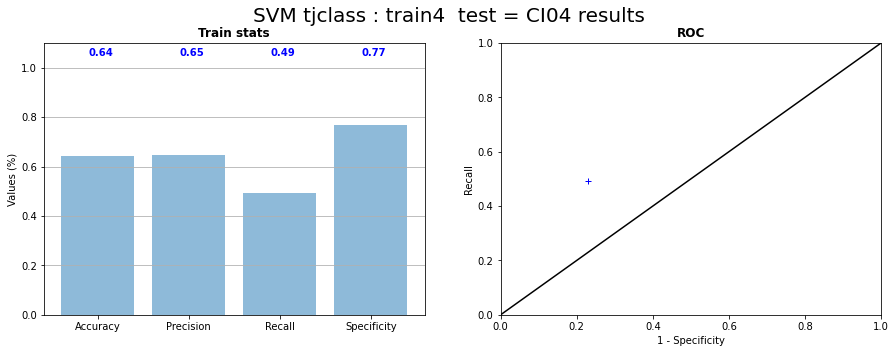

In [139]:
acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
spec = cm[0,0] / (cm[0,0] + cm[0,1])
utils.plot_lstats(acc,prec,rec,spec,model="SVM tjclass : train4  test = CI04")

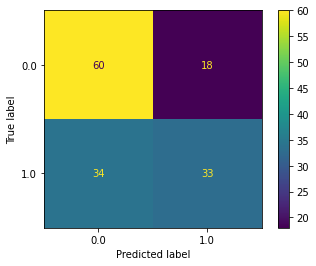

In [140]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)  
plt.show()

In [9]:
maps = ds_CI04.aita.dist2eachTJ()
imshape = np.shape(ds_CI04.grainId)
M = ds_CI04.aita.TJ_map()
coords = M.T[0:2]


In [143]:
tj_to_skip = tj_to_skip_CI04

In [144]:
tj_to_skip.reverse()
for i in tj_to_skip:
    coords = np.delete(coords,i,1)

In [145]:
from matplotlib import colors
col = -(y_pred+2*np.array(y_test))
cmap = colors.ListedColormap(['green','red','blue','gray'])
bounds=[-3.5,-2.5,-1.5,-0.5,0.5]
norm = colors.BoundaryNorm(bounds, cmap.N)



In [14]:
imshape

(554, 534)

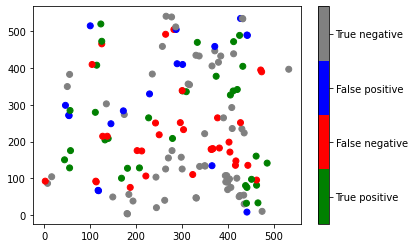

In [146]:
plot = plt.scatter(coords[0],coords[1],c=col,cmap=cmap,norm=norm)
cbar = plt.colorbar(plot, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-3, -2, -1,0])

cbar.set_ticklabels(["True positive","False negative","False positive","True negative"])

-------------------------------
# CV

In [5]:
names = ["TJ_CI02","TJ_CI04","TJ_CI06","TJ_CI09","TJ_CI21"]
vars = [X1,X2,X3,X4,X5]
group = [y1,y2,y3,y4,y5]

array([0.2, 0.5, 0.8, 1.1, 1.4, 1.7, 2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8,
       4.1, 4.4, 4.7, 5. ])

In [17]:
for w in tqdm(np.linspace(0.2,5,17)):
    acc = []
    prec = []
    recall = []
    specif = []
    confmat = []

    for i in range(len(vars)):
        ln = names.copy()
        ln.pop(i)
        lX = vars.copy()
        lX.pop(i)
        ly = group.copy()
        ly.pop(i)

        X_test = vars[i]
        y_test = group[i]

        for j in range(len(lX)):
            if j == 0:
                X_train = lX[j]
                y_train = ly[j]
            else:
                X_train = pd.concat([X_train,lX[j]])
                y_train = pd.concat([y_train,ly[j]])

        #print("Learning :\n \tTrain : ",ln,"\n \tTest : ",names[i])

        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        clf = svm.SVC(class_weight={1:w})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        cm = metrics.confusion_matrix(y_test, y_pred)

        if (metrics.recall_score(y_test, y_pred) < (1-(cm[0,0] / (cm[0,0] + cm[0,1])))):
            y_pred = 1- y_pred
            cm = metrics.confusion_matrix(y_test, y_pred)

        acc.append(metrics.accuracy_score(y_test, y_pred))
        prec.append(metrics.precision_score(y_test, y_pred))
        recall.append(metrics.recall_score(y_test, y_pred))
        specif.append(cm[0,0] / (cm[0,0] + cm[0,1]))
        confmat.append(cm.flatten())

    print("Learning done")

    results = [acc,prec,recall,specif]

    np.savetxt("../RUN_GRICAD/res/CV_TJ-SVM-w"+str(round(w,1))+"_res.txt",results)
    np.savetxt("../RUN_GRICAD/res/CV_TJ-SVM-w"+str(round(w,1))+"_confmats.txt",np.array(confmat))

  0%|          | 0/17 [00:00<?, ?it/s]

/home/manceauxr/anaconda3/envs/Working_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manceauxr/anaconda3/envs/Working_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manceauxr/anaconda3/envs/Working_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manceauxr/anaconda3/envs/Wor

Learning done


/home/manceauxr/anaconda3/envs/Working_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manceauxr/anaconda3/envs/Working_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done
Learning done


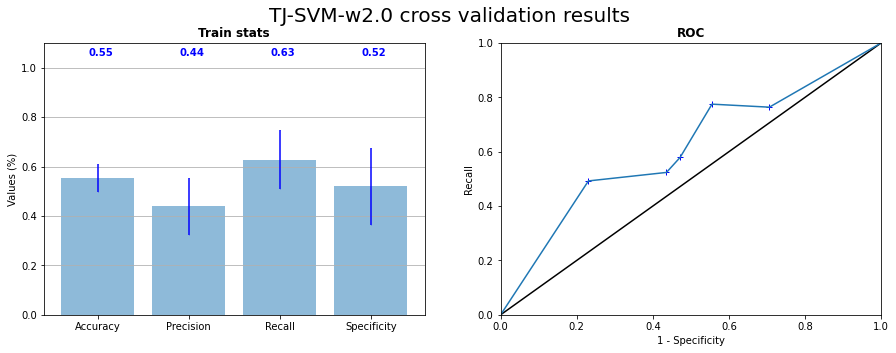

In [129]:
utils.plot_res_CV("../RUN_GRICAD/res/CV_TJ-SVM-w2.0_res.txt")

In [121]:
import glob

files = glob.glob('../RUN_GRICAD/res/CV_TJ*')

In [122]:
m_rec = []
m_aspec = []

for f in files:
    res = np.loadtxt(f)
    m_rec.append(np.mean(res[2]))
    m_aspec.append(np.mean(1-res[3]))

x, y = np.array(m_aspec), m_rec

Text(0.5, 0, '1 - Specificity')

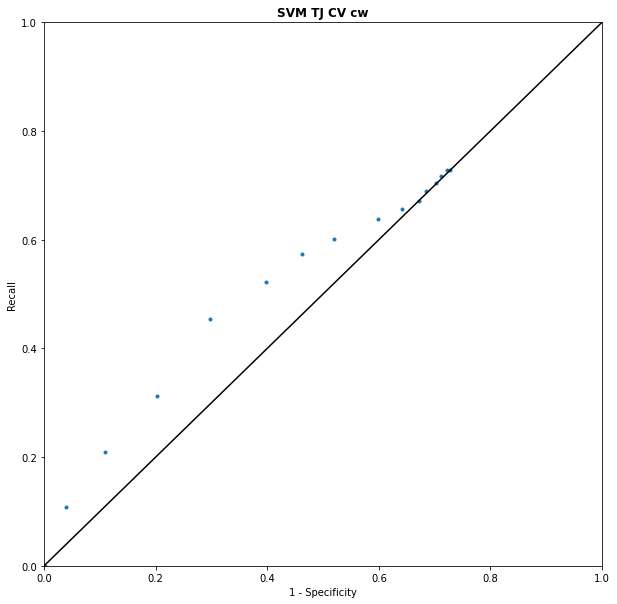

In [131]:
fig, ax = plt.subplots(figsize=(10,10))

plt.plot(x,y,'.')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([0,1],[0,1],"black")

ax.set_title('SVM TJ CV cw',fontweight='bold')
ax.set_ylabel('Recall')
ax.set_xlabel('1 - Specificity')

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'ROC of models cross validation'}, xlabel='1 - Specificity', ylabel='Recall'>)

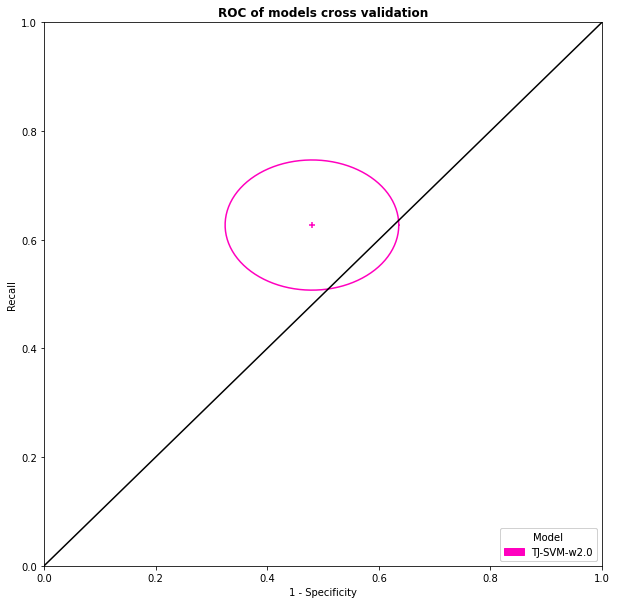

In [130]:
utils.ROC_patch(["../RUN_GRICAD/res/CV_TJ-SVM-w2.0_res.txt"])

In [5]:
X = pd.concat((X1,X2,X3,X4,X5))


In [6]:
f = plt.figure(figsize=(10,10))
plt.matshow(X.corr(),fignum=f.number,vmin=-1,vmax = 1)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.yticks(range(X.shape[1]), X.columns)
cb = plt.colorbar()
plt.title('Correlation Matrix', fontsize=16);

In [7]:
X.corr()

schmid1   schmid2   schmid3  diff_schmid1  diff_schmid2  \
schmid1       1.000000  0.180439  0.175820     -0.141869     -0.147162   
schmid2       0.180439  1.000000  0.199164     -0.140240     -0.167573   
schmid3       0.175820  0.199164  1.000000     -0.205963      0.013862   
diff_schmid1 -0.141869 -0.140240 -0.205963      1.000000      0.119699   
diff_schmid2 -0.147162 -0.167573  0.013862      0.119699      1.000000   
diff_schmid3 -0.051231  0.049270 -0.039045      0.136426      0.331949   
misangle1     0.140562  0.086249  0.163602      0.170006      0.180078   
misangle2     0.085556  0.113901  0.109675      0.167261      0.220895   
misangle3     0.129708  0.122417  0.091933      0.118035      0.145022   
relative_an  -0.167996 -0.143117 -0.154160     -0.166960     -0.205453   
eqStrain     -0.149533  0.008926 -0.028166      0.050492     -0.040243   
eqStress     -0.074880  0.074299  0.020401      0.128285      0.056728   
act_pr       -0.145146  0.016837 -0.048917      0.066625      0.042495   
act_py       -0.083112 -0.052123 -0.004495      0.018602      0.008691   
work         -0.154001  0.007563 -0.013941      0.085414      0.037239   
dist1neigh    0.017128 -0.080366 -0.052259      0.066449      0.029364   
nb_pix_g1     0.010280  0.085887  0.010636      0.042915     -0.015415   
nb_pix_g2     0.015722 -0.055848  0.016026      0.079425      0.098019   
nb_pix_g3    -0.003270  0.014015 -0.055908     -0.019306      0.059154   

              diff_schmid3  misangle1  misangle2  misangle3  relative_an  \
schmid1          -0.051231   0.140562   0.085556   0.129708    -0.167996   
schmid2           0.049270   0.086249   0.113901   0.122417    -0.143117   
schmid3          -0.039045   0.163602   0.109675   0.091933    -0.154160   
diff_schmid1      0.136426   0.170006   0.167261   0.118035    -0.166960   
diff_schmid2      0.331949   0.180078   0.220895   0.145022    -0.205453   
diff_schmid3      1.000000   0.148992   0.187195   0.190431    -0.210377   
misangle1         0.148992   1.000000   0.331117   0.399397    -0.741342   
misangle2         0.187195   0.331117   1.000000   0.312363    -0.704947   
misangle3         0.190431   0.399397   0.312363   1.000000    -0.729213   
relative_an      -0.210377  -0.741342  -0.704947  -0.729213     1.000000   
eqStrain          0.026793   0.025813  -0.022807  -0.042720     0.033607   
eqStress          0.150260   0.130970   0.118739   0.096339    -0.125330   
act_pr            0.049336   0.049565   0.099701   0.059455    -0.093141   
act_py           -0.009384  -0.015064   0.068696   0.027928    -0.030950   
work              0.067731   0.066616   0.087851   0.060634    -0.085580   
dist1neigh        0.038625   0.118294   0.117173   0.000251    -0.091626   
nb_pix_g1         0.052564   0.100518   0.009851  -0.009744    -0.025031   
nb_pix_g2         0.106615   0.104823   0.089102  -0.052494    -0.045026   
nb_pix_g3         0.024161   0.081461   0.044363   0.026119    -0.062083   

              eqStrain  eqStress    act_pr    act_py      work  dist1neigh  \
schmid1      -0.149533 -0.074880 -0.145146 -0.083112 -0.154001    0.017128   
schmid2       0.008926  0.074299  0.016837 -0.052123  0.007563   -0.080366   
schmid3      -0.028166  0.020401 -0.048917 -0.004495 -0.013941   -0.052259   
diff_schmid1  0.050492  0.128285  0.066625  0.018602  0.085414    0.066449   
diff_schmid2 -0.040243  0.056728  0.042495  0.008691  0.037239    0.029364   
diff_schmid3  0.026793  0.150260  0.049336 -0.009384  0.067731    0.038625   
misangle1     0.025813  0.130970  0.049565 -0.015064  0.066616    0.118294   
misangle2    -0.022807  0.118739  0.099701  0.068696  0.087851    0.117173   
misangle3    -0.042720  0.096339  0.059455  0.027928  0.060634    0.000251   
relative_an   0.033607 -0.125330 -0.093141 -0.030950 -0.085580   -0.091626   
eqStrain      1.000000  0.531051  0.554258  0.381707  0.794803    0.079752   
eqStress      0.531051  1.000000  0.322195  0.295496  0.603438    0.097757   